### Content

- Import neccessary libraries
- Treat outliers
- Exploratory data analysis
- Statistical modelling
- Final note

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# statistical lubraries
from scipy.stats import shapiro
import scipy.stats as stats

# disable warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./cookie_cats.csv')
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


In [4]:
data.userid.duplicated().value_counts()

False    90189
Name: userid, dtype: int64

In [28]:
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

###### Investigating the versions to see what we can make out of each category

In [5]:
data.groupby('version').sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'max'])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17,52.456264,256.716423,49854
gate_40,45489,16,51.298776,103.294416,2640


We also ivestigate the distribution before treating the outliers

In [6]:
def plot_distribution(dataframe):
    fig, axes = plt.subplots(1,2, figsize=(14, 6))
    sns.histplot(dataframe, x='sum_gamerounds', label ='histogram', multiple='dodge', hue='version',
               shrink=.8, binwidth=10, ax=axes[0])
    sns.boxplot(x=dataframe['version'], y=dataframe['sum_gamerounds'], ax=axes[1])
    axes[0].set_xlim(0, 200)
    axes[1].set_yscale('log')
    axes[0].set_title('Histogram Distribution', fontsize=14)
    axes[1].set_title('Distribution by Version', fontsize=14)
    plt.show()       

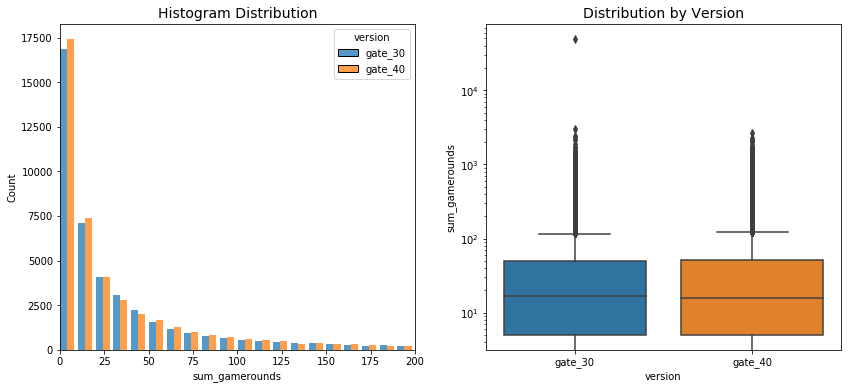

In [7]:
plot_distribution(data)

As seen from the above plot, in the boxplot ,the presence of outliers. We will have to filter them out to see the real distributed values of our data.

In [8]:
# Making a copy of our dataframe to keep track of the changes while filtering out the outliers
df = data.copy()

###### Removing outliers

__The Zscore__ is an important concept in statistics. Z score is also called the standard score,the score helps to understand if a data value is greater or smaller than the mean and how far away it is from the mean. More specifically, Z score tells how many standard deviations away a data is from the mean.
__Z SCORE = (X-MEAN)/STD.DEVIATION__

In [9]:
def filter_outliers(dataframe, z_thresh=3):
    # constrains will contain 'True' or 'False' depending on if its a value below the threshold
    constrains = dataframe.select_dtypes(include=[np.number]).apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, result_type='reduce').all(axis=1)
    #drop (inplace) values set to be rejected
    dataframe.drop(dataframe.index[~constrains], inplace=True)

In [10]:
filter_outliers(df)

In [11]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [12]:
print('The shape of data before removing outliers:' + str(data.shape))
print('-----------------------------------------')
print('The shape of data after removing outliers:' + str(df.shape))

The shape of data before removing outliers:(90189, 5)
-----------------------------------------
The shape of data after removing outliers:(89764, 5)


###### Before filtering outliers, we had the record

In [13]:
data.groupby('version').sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'max'])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17,52.456264,256.716423,49854
gate_40,45489,16,51.298776,103.294416,2640


###### After removing outliers, we then got

In [14]:
df.groupby('version').sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'max'])

,count,median,mean,std,max
version,,,,,
gate_30,44500,17,47.486494,81.340691,637
gate_40,45264,16,46.951706,79.976331,637


###### Post outlier distribution

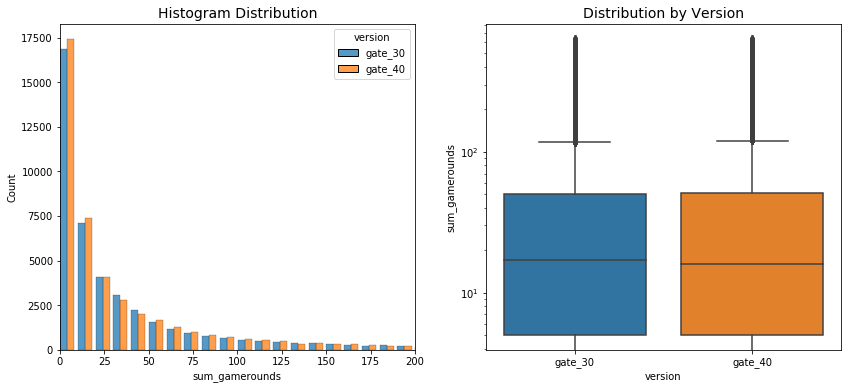

In [15]:
plot_distribution(df)

From the above plot we can see between the versions in the boxplot, there are no difference from the two versions as they appear similar in distribution after the outliers were removed. Which is expected,and the more reason why a statistical test analysis needs to be carried out to discover if they are truly similar or not. But before that, it would be nice to dig deeper into the data to discover some patterns with player retention

#### Exploratory Analyses

It would be nice to find out palyer retention trend after first day of installation

In [16]:
print(df['retention_1'].value_counts())

False    50020
True     39744
Name: retention_1, dtype: int64


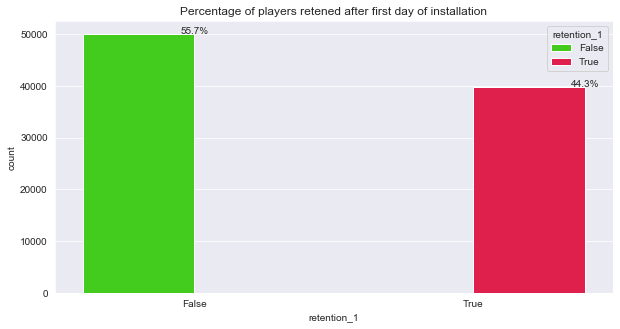

In [17]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
ax = sns.countplot(x='retention_1', data=df, palette ='prism', hue ='retention_1')
plt.title('Percentage of players retened after first day of installation')
index = ['True','False']
total = float(len(df))
#plt.xticks(index,['True', 'False']. fontsize = 15)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    height = p.get_height()
    ax.annotate(percentage, (x, y), ha = 'center')
    
plt.show()

Player retention trend after 7th day of installation

In [18]:
print(df['retention_7'].value_counts())

False    73394
True     16370
Name: retention_7, dtype: int64


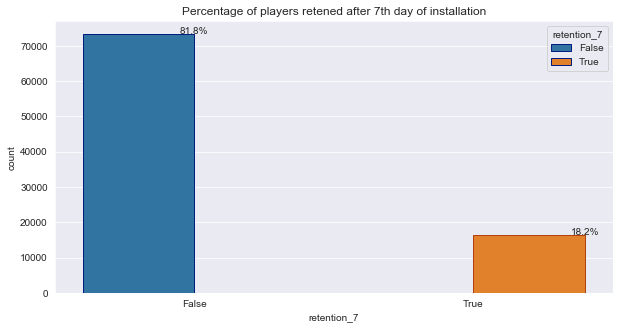

In [19]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
ax = sns.countplot(x='retention_7', data=df, edgecolor=sns.color_palette("dark", 7), hue ='retention_7')
plt.title('Percentage of players retened after 7th day of installation')
index = ['True','False']
total = float(len(df))
#plt.xticks(index,['True', 'False']. fontsize = 15)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    height = p.get_height()
    ax.annotate(percentage, (x, y), ha = 'center')
    
plt.show()

##### We have have a very large number of players who churned after the first day of installation and the 7th day, which is a bad sign, with 56.7% churned and just 44.3% retained after the first day and 81% players churning after the 7th day with just only 18% retained after the 7th day. This could possibly mean that:

- The number of players who churned didnt really like the game.

- Perhaps the difficulty level is quite high

- They preferred other games they were playing at that moment or dont have the time to play the game

- Comparing the 1st and 7th day after installation, one would notice players tend to drop as time progresses

It would also be nice to find out the total number of players for each gamerouds

In [20]:
df.groupby('sum_gamerounds').userid.count().reset_index().head(25)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


###### Observation:
Something interesting here, we have __3994__ players who installed the game but never played it for once.

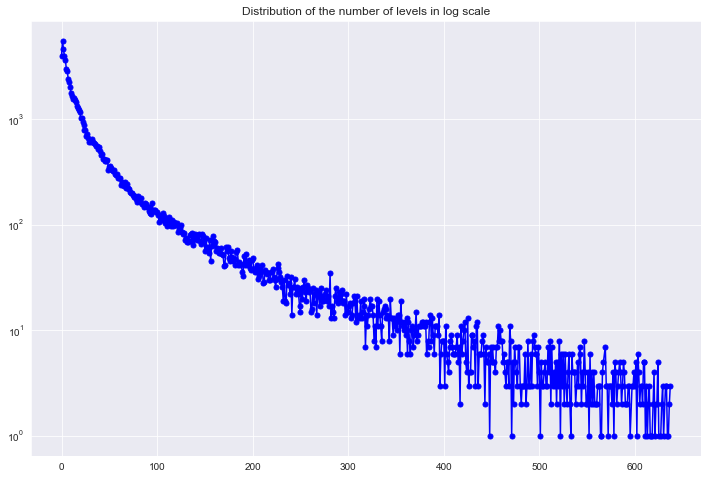

In [24]:
plt.subplots(figsize=(12, 8))
plt.plot(df.groupby('sum_gamerounds')['userid'].agg('count'), 'bo-', markersize=5)
plt.yscale('log')
plt.title('Distribution of the number of levels in log scale')
plt.show()

We also try to discover how many players who made it to __gate30__ and __gate40__ levels respectively.

In [30]:
df.groupby('sum_gamerounds').userid.count().loc[[30, 40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

###### Compairing the  summary statistics of retention variables by version with sum_gamerounds 

In [31]:
df.groupby(['version', 'retention_1']).sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'max'])

count  median       mean         std  max
version retention_1                                           
gate_30 False        24656       6  16.055200   32.782692  551
        True         19844      47  86.539609  103.678971  637
gate_40 False        25364       6  16.128686   33.013773  547
        True         19900      48  86.237889  102.006952  637

In [32]:
df.groupby(['version', 'retention_7']).sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'max'])

count  median        mean         std  max
version retention_7                                            
gate_30 False        36189      11   25.609660   41.629075  637
        True          8311     101  142.745879  129.317929  637
gate_40 False        37205      11   25.700443   41.429712  612
        True          8059     108  145.059809  127.640744  637

Since both classes appear similar given from the summary statistics, we therefore test if both classes are statistically significant

In [55]:
df.groupby('version').retention_1.mean(), df.groupby('version').retention_7.mean()

(version
 gate_30    0.445933
 gate_40    0.439643
 Name: retention_1, dtype: float64,
 version
 gate_30    0.186764
 gate_40    0.178044
 Name: retention_7, dtype: float64)

We can see that the gate at level 30 has a slight player retention than gate40 level

### A/B MODEL TESTING¶
__Assumptions__:

- Check for Nomality
- If Normal Distribution, check for homogeneity

In [33]:
A = df[df['version']=='gate_30']['sum_gamerounds']
B = df[df['version']=='gate_40']['sum_gamerounds']

_Check for Normality using the Quantile_plot_

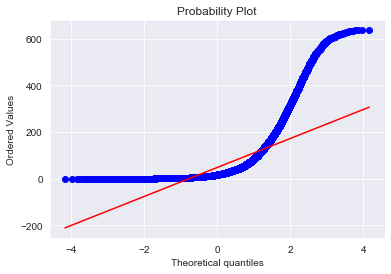

In [34]:
# testing for A(gate30)
stats.probplot(A, plot=sns.mpl.pyplot)
plt.show()

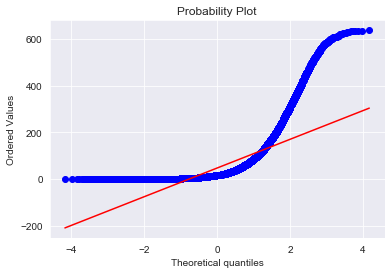

In [35]:
# testing for B(gate40)
stats.probplot(B, plot=sns.mpl.pyplot)
plt.show()

We see quantile plot for both class looks similar from the above plots. Now are they both significant? 

##### Testing for Normality
- H0 : Distribution is Normal/ not significant (Null Hypothesis)
- H1 : Distribution is not Normal/ significant (Alternative Hypothesis)

###### Shapiro-Wilk test

In [41]:
_, pvalue1 = stats.shapiro(A)
_, pvalue2 = stats.shapiro(B)
pvalue1, pvalue2

(0.0, 0.0)

###### D'Agostino's K-squared test

In [42]:
_, pvalue1 = stats.normaltest(A)
_, pvalue2 = stats.normaltest(B)
pvalue1, pvalue2

(0.0, 0.0)

###### Chi squared  Normality test

In [43]:
_, pvalue1 = stats.chisquare(A)
_, pvalue2 = stats.chisquare(B)
pvalue1, pvalue2

(0.0, 0.0)

###### Jarque-Bera Normality Test

In [47]:
_, pvalue1 = stats.jarque_bera(A)
_, pvalue2 = stats.jarque_bera(B)
pvalue1, pvalue2

(0.0, 0.0)

##### Kolmogrov-Smirnov Normality Test

In [48]:
_, pvalue1 = stats.kstest(A, cdf='norm')
_, pvalue2 = stats.kstest(B, cdf='norm')
pvalue1, pvalue2

(0.0, 0.0)

Following our initial Hypothesis assumption, we can conclude from here that our data is not Gausian i.e Normal when __pvalue < 0.05__ we reject the Null hypothesis

######  Anderson-Darlin Normality Test

In [50]:
res = stats.anderson(A)
for critical_value, significance_level in zip(res.critical_values, res.significance_level):
    print(f"Distribution {'is' if res.statistic < critical_value else 'not is'} Gaussian at significance level ={significance_level}")

Distribution not is Gaussian at significance level =15.0
Distribution not is Gaussian at significance level =10.0
Distribution not is Gaussian at significance level =5.0
Distribution not is Gaussian at significance level =2.5
Distribution not is Gaussian at significance level =1.0


###### Check for the equality of distribution
We can achieve this by applying a Non-parametric test which is known as __Mann Whitneyu__,used to compare two groups

- H0 : Null hypothesis (pvalue > 0.05)
- H1 : Alternate Hypothesis ( pvalue < 0.05)

In [52]:
_, pvalue = stats.mannwhitneyu(A, B)
pvalue

0.018038103112169034

In [53]:
pvalue < 0.05

True

###### With the above result we therefore conclude Significance Exist and reject the Null hypothesis

##                                                   Final Note                                                   ##

- Going by our analyses, players played the game more often after the first day of installation, but tend to churn as time goes on. Could it be they didn't like the game, get bored with the game overtime or perhaps the difficulty level of the game? Maybe player gift will help with player retention
- We also oberved from the analyses that the gate at level 30 has more player retention than when it is placed at level 40, even though they both differ by a margin with the same average retention rate.
- Our analyses also revealed our data is not similar, even though they appear similar as they are statistically significant as given by the A/B Test result with __Mann Whitenyu pvalue of 0.018__

In [21]:
!pip install -U seaborn

  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
